In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import rayleigh


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data -  Weather and Air quality
weather_df = pd.read_csv("/content/drive/MyDrive/Exam/london_weather.csv")
quality_df = pd.read_csv("/content/drive/MyDrive/Exam/air-quality-london-time-of-day.csv")

#display(weather_df)
#quality_df.head(2)


In [3]:
# Data Cleaning
# Air Quality
df_qdate = quality_df.drop(columns='GMT') # drop time
df_qdate.fillna(0,inplace=True)  # fill NA
df_qdate['Month']=pd.to_datetime(df_qdate['Month'],yearfirst=True) # convert month col to date format

# Weather
df_w = weather_df
df_w.fillna(0,inplace=True)


In [4]:
# Mean quality for each month
df_qdate_gr = df_qdate.set_index('Month')
df_qdate_gr = df_qdate_gr.groupby(pd.Grouper(freq='D'))
df_qdate_mean = df_qdate_gr.mean()

df_qdate_mean.dropna(inplace=True)


In [5]:
# Fix date format issue (from yyyy-dd-mm to yyyy-mm-dd)
date_month = pd.date_range(start='2008-01-01', end='2019-07-01', freq='MS') # genrate new date col for each month
df_qdate_mean['date'] = date_month
df_qdate_mean.set_index('date',inplace=True)


In [6]:
# Fix date format issue
date_range = pd.date_range(start='1979-01-01', end='2020-12-31', freq='D')
weather_df['date2'] = date_range

weather_df_new = weather_df.drop(columns='date')

# mean of weather
weather_df_new.set_index('date2',inplace=True)
df_wdate_gr = weather_df_new.groupby(pd.Grouper(freq='M'))
df_wdate_mean = df_wdate_gr.mean()

date_range_month = pd.date_range(start='1979-01-01', end='2020-12-01', freq='MS')
print(date_range_month.size)
df_wdate_mean['date'] = date_range_month
df_wdate_mean.set_index('date',inplace=True)



504


In [7]:
# merge both ds based on date
df_merge = pd.merge(df_qdate_mean, df_wdate_mean, left_index=True, right_index=True)
df_merge.reset_index(inplace=True)

# Add columns for total roadside pollution and background pollution

df_merge['Total Roadside'] = df_merge.iloc[:,1:8].sum(axis=1)
df_merge['Total Background'] = df_merge.iloc[:,8:14].sum(axis=1)
df_merge.head(2)

,date,London Mean Roadside:Nitric Oxide (ug/m3),London Mean Roadside:Nitrogen Dioxide (ug/m3),London Mean Roadside:Oxides of Nitrogen (ug/m3),London Mean Roadside:Ozone (ug/m3),London Mean Roadside:PM10 Particulate (ug/m3),London Mean Roadside:PM2.5 Particulate (ug/m3),London Mean Roadside:Sulphur Dioxide (ug/m3),London Mean Background:Nitric Oxide (ug/m3),London Mean Background:Nitrogen Dioxide (ug/m3),...,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,Total Roadside,Total Background
0,2008-01-01,0.0,55.5125,0.0,29.512500,24.970833,14.675,4.216667,0.0,42.345833,...,1.941935,30.419355,10.412903,7.390323,4.709677,2.225806,101234.516129,0.0,128.887500,101.679167
1,2008-02-01,0.0,75.9250,0.0,20.316667,39.487500,28.775,7.554167,0.0,60.241667,...,4.482759,67.137931,10.989655,6.500000,2.031034,0.531034,102306.551724,0.0,172.058333,125.275000


In [8]:
df_roadside = df_merge.iloc[:,14:24]
df_bckgrnd = df_merge.iloc[:,14:23]
df_bckgrnd['Total Background'] = df_merge.iloc[:,24]

df_roadside.head(2)

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,Total Roadside
0,5.419355,1.941935,30.419355,10.412903,7.390323,4.709677,2.225806,101234.516129,0.0,128.887500
1,3.724138,4.482759,67.137931,10.989655,6.500000,2.031034,0.531034,102306.551724,0.0,172.058333


Find the highest corr value after 1:
 global_radiation  max_temp            0.849082
max_temp          global_radiation    0.849082
sunshine          global_radiation    0.929564
global_radiation  sunshine            0.929564
max_temp          min_temp            0.969485
min_temp          max_temp            0.969485
                  mean_temp           0.990601
dtype: float64


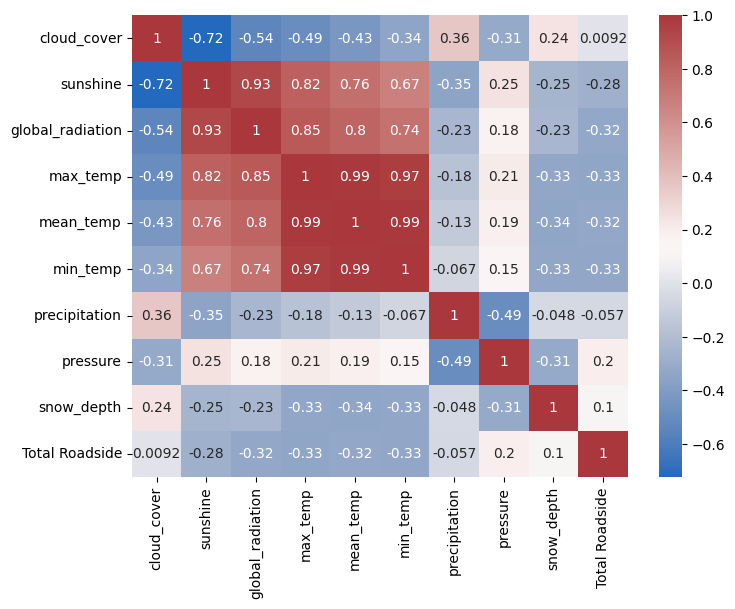

In [9]:
#Correlation between features

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

feature_df = pd.merge(df_roadside.iloc[:,0:9], df_roadside.iloc[:,9], left_index=True, right_index=True)
#display(feature_df)

corr = feature_df.corr()
#display(corr)

sorted_mat = corr.unstack().sort_values() # Sort corr values
print("Find the highest corr value after 1:\n",sorted_mat[-20:-13])
sns.heatmap(corr, cmap="vlag",annot=True,ax=ax)

# Test
random_values = rayleigh.rvs(loc=-0.094, scale=1.43, size=500, random_state=None)
for value in random_values:
    df_roadside = pd.concat([df_roadside, pd.DataFrame({'precipitation': [value]})], ignore_index=True)
df_roadside= df_roadside.round(1)
df_roadside_test = df_roadside
df_roadside = df_roadside.interpolate()


In [10]:
# Normalize
sc = StandardScaler()
df_roadside_norm_test = pd.DataFrame(sc.fit_transform(df_roadside))
df_roadside_norm = pd.DataFrame(sc.fit_transform(df_roadside))

In [11]:
# Split into training and testing
x_train, x_test, y_train, y_test = train_test_split(df_roadside_norm.iloc[:,0:9],df_roadside_norm.iloc[:,-1],test_size=0.35, random_state=55)
#19,55

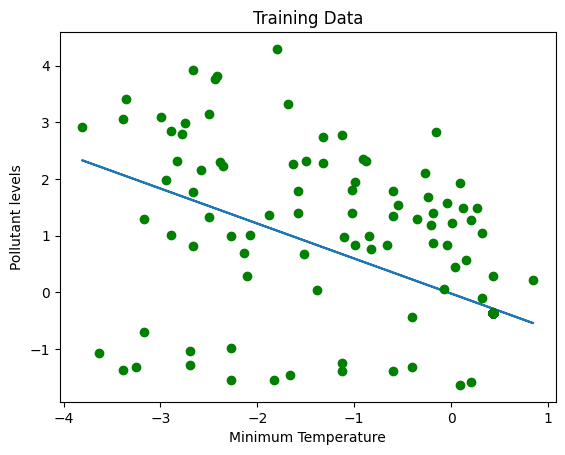

In [12]:
x = x_train.iloc[:,5]
y = y_train


# fit a linear curve.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b


fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.set_xlabel("Minimum Temperature")
ax.set_ylabel("Pollutant levels")
ax.set_title("Training Data")
ax.plot(x, y, 'o', color='Green')
plt.show()

In [13]:

# Regression model on training data to find outliers
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error


pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('en', ElasticNet())
])
param_m = {
    'poly__degree': [1, 2, 3],       # Polynomial degree
    'en__alpha': [0.2, 0.1, 0.3]   # ElasticNet regularization strength
}

model = GridSearchCV(estimator=pipeline, param_grid=param_m, cv=6)
model.fit(x_train,y_train)
best_alpha = model.best_params_
print("Best Alpha:", best_alpha)
best_elastic_net = model.best_estimator_

# Make predictions
predictions = best_elastic_net.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


#model.fit(x_train, y_train)
y_pred = model.predict(x_train)
print("Train Score: ",model.score(x_train,y_train))
print("Test Score: ",model.score(x_test,y_test))



Best Alpha: {'en__alpha': 0.1, 'poly__degree': 1}
Mean Squared Error: 0.4277888208191446
Train Score:  0.44987262359437574
Test Score:  0.6528350925264019


In [14]:
# outlier detection and elimination
from scipy import stats

res = y_train - y_pred
z_scores = stats.zscore(res)
threshold =2
outlier_mask = np.abs(z_scores) > threshold


bck_train = pd.merge(x_train, y_train, left_index=True, right_index=True)
outlier_residuals = y_train[outlier_mask]
outlier_indices = bck_train.index[outlier_mask]
#outlier_indices = np.where(outlier_mask)[0]
#print(outlier_residuals.shape)
#list(outlier_indices)


In [15]:

bck_train = bck_train.drop(list(outlier_indices)) #Drop outliers
bx, by = bck_train.iloc[:,0:9], bck_train.iloc[:,-1]

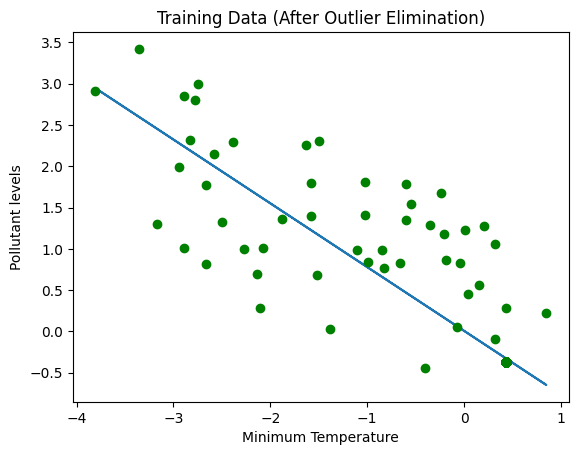

In [16]:

x = bx.iloc[:,5]
y = by

# fit a linear curve
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.set_xlabel("Minimum Temperature")
ax.set_ylabel("Pollutant levels")
ax.set_title("Training Data (After Outlier Elimination)")
ax.plot(x, y, 'o', color='Green')
plt.show()

In [17]:

model.fit(bx, by)
y_pred = model.predict(x_test)
mse2 = mean_squared_error(y_test, y_pred)
print("Train Score: ",model.score(bx,by))
print("Test Score: ",model.score(x_test,y_test))
print("Mean Squared Error:", mse2)



Train Score:  0.8271233087998903
Test Score:  0.7040301711610533
Mean Squared Error: 0.36470444261906276
